```
Task   : Normalizing Flows for Fast Detector Simulation (Task 2)
Author : Aditya Ahuja 
```

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initial-Dataset-Analysis" data-toc-modified-id="Initial-Dataset-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initial Dataset Analysis</a></span></li><li><span><a href="#Constructing-the-Parsed-Dataset" data-toc-modified-id="Constructing-the-Parsed-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Constructing the Parsed Dataset</a></span></li><li><span><a href="#Outlining-the-Training-Pipeline" data-toc-modified-id="Outlining-the-Training-Pipeline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Outlining the Training Pipeline</a></span></li><li><span><a href="#Training-The-Model" data-toc-modified-id="Training-The-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training The Model</a></span><ul class="toc-item"><li><span><a href="#Training-Curves-from-Tensorboard" data-toc-modified-id="Training-Curves-from-Tensorboard-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Training Curves from Tensorboard</a></span></li></ul></li><li><span><a href="#Evaluate-the-Trained-Model" data-toc-modified-id="Evaluate-the-Trained-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluate the Trained Model</a></span></li></ul></div>

# Initial Dataset Analysis

In [1]:
##### Flags #####

DO_CACHE = False      # Recreate all the caches ?
DO_TRAINING = False   # Train the model again ?
DO_ANALYSIS = True    # Display dataset and result analysis?

#################

# Root task folder.
import os
ROOT = os.path.dirname(os.getcwd())+ '/' 

# Input format of files in $ROOT/data
INPUT_FORMAT = 'Boosted_Jets_Sample-{}.snappy.parquet'

In [2]:
''' DOING IMPORTS '''

import os
import cv2
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from tqdm.auto import tqdm, trange

# Set Numpy Print Options
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [3]:
''' CREATE AND SET DATA/CACHE DIRECTORIES '''

# ROOT = os.path.dirname(os.getcwd()) + '/'
DATA_ROOT = ROOT + "data/"
CACHE_ROOT = ROOT + "cache/"

os.chdir(ROOT)
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(CACHE_ROOT, exist_ok=True)

print('Directory Structure [Excluding Log/Temp Files]:')
! tree -I 'model*|temp__*'

Directory Structure [Excluding Log/Temp Files]:
.
├── cache
│   ├── X_dict.pkl
│   ├── X_dict_0.pkl
│   ├── X_dict_1.pkl
│   ├── X_dict_2.pkl
│   ├── X_dict_3.pkl
│   └── X_dict_4.pkl
├── data
│   ├── Boosted_Jets_Sample-0.snappy.parquet
│   ├── Boosted_Jets_Sample-1.snappy.parquet
│   ├── Boosted_Jets_Sample-2.snappy.parquet
│   ├── Boosted_Jets_Sample-3.snappy.parquet
│   └── Boosted_Jets_Sample-4.snappy.parquet
├── get_dataset.py
├── logs
└── nbs
    └── task2.ipynb

4 directories, 13 files


In [4]:
''' FUNCTIONS: DATA/INSTANCE LOADING '''

def load_dataset(dataset_file):
    f_path = DATA_ROOT + dataset_file
    data = pq.read_table(f_path)
    return data
        
def get_instance(data, idx):
    assert idx < 32000
    instance = np.array(data[0][idx].as_py())
    return instance

In [5]:
''' FUNCTIONS: PARSING/VISUALIZING IMAGES '''

def parse_img(track_img, reduce=False):
    if reduce:
        track_img = cv2.resize(track_img, dsize=(25,25))
        # plt.imshow(track_img)
        
    x_pos = []
    y_pos = []
    val = []
    for x_idx in range(track_img.shape[0]):
        for y_idx in range(track_img.shape[1]):
            if track_img[x_idx][y_idx] != 0:
                val.append(track_img[x_idx][y_idx])
                x_pos.append(x_idx)
                y_pos.append(y_idx)
    
    if reduce:
        x_pos = [5*v for v in x_pos]
        y_pos = [5*v for v in y_pos]
    # print(len(x_pos), len(y_pos), len(val))
    return x_pos, y_pos, val

def vis(img, title=None, scale=1000, cmap='gist_heat', reduce=False):        
    x_pos, y_pos, val = parse_img(img, reduce)
    if scale:
        sz = np.array(np.abs(val))*scale
    else:
        sz = np.ones_like(val) * 10
        
    plt.figure(figsize=[14,6], facecolor='#f0f0f0')
    cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
    sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 125)
    plt.ylim(0, 125)
    plt.grid()
    if title:
        plt.title(title)
    plt.show()

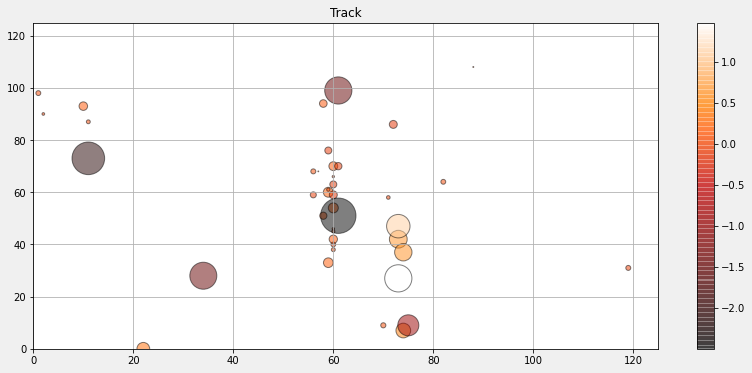

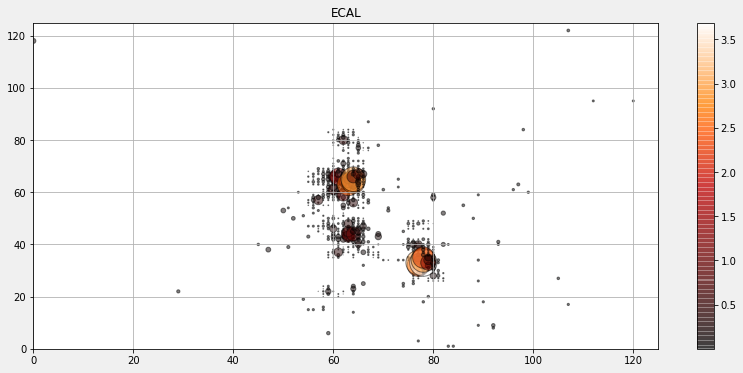

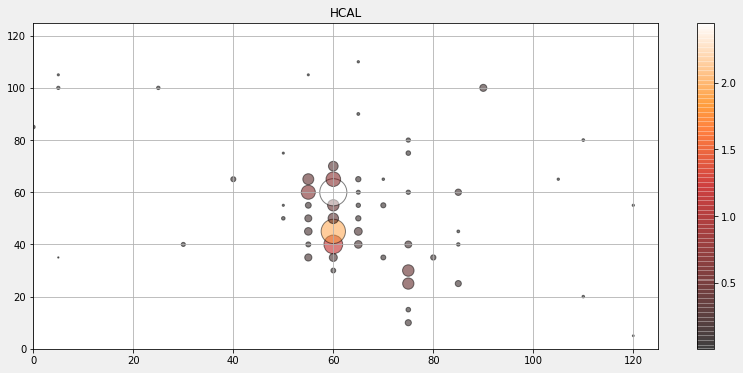

In [7]:
''' ANALYSING PARSED IMAGES '''

if DO_ANALYSIS:
    data = load_dataset(INPUT_FORMAT.format(0))
    
    img = get_instance(data, 2)
    vis(img[0], scale=500, title='Track')
    vis(img[1], scale=200, title='ECAL')
    vis(img[2], scale=300, title='HCAL', reduce=True)

# Constructing the Parsed Dataset

`X_track`: 
   - Array containing information about each events `track` channel.
   - Each element in `X_track` contains three arrays (of equal lengths) corresponding to `(X position, Y position, Value)`.
   - Each element in these arrays contains an instance's respective value. 

```
X_track : [
    [X_position: [], Y_position: [], Value: []],           # Event 1
    [X_position: [], Y_position: [], Value: []],           # Event 2
    [X_position: [], Y_position: [], Value: []],           # Event 3
    ...
    [X_position: [], Y_position: [], Value: []],           # Event n
]

```

Similarly we construct arrays `X_ECAL` and `X_HCAL`.

In [8]:
''' FUNCTIONS: PARSING/MERGING/CACHING DATASETS '''

def cache_dataset(file_name, X_track, X_ECAL, X_HCAL):
    X_dict = {
        'X_track': X_track,
        'X_ECAL': X_ECAL,
        'X_HCAL': X_HCAL,
    }
    with open(CACHE_ROOT + file_name, 'wb') as f:
        pkl.dump(X_dict, f)
        
def load_cached_dataset(file_name):
    with open(CACHE_ROOT + file_name, 'rb') as f:
        X_dict = pkl.load(f)
    X_track = X_dict['X_track']
    X_ECAL = X_dict['X_ECAL']
    X_HCAL = X_dict['X_HCAL']
    return X_track, X_ECAL, X_HCAL

def parse_dataset(data, save_datafile, reduce):
    X_track = []
    X_ECAL = []
    X_HCAL = []

    for i in trange(len(data)):
        img = get_instance(data, i)
        X_track.append(parse_img(img[0]))
        X_ECAL.append(parse_img(img[1]))
        X_HCAL.append(parse_img(img[2], reduce=reduce))

    # print(len(X_track), len(X_ECAL), len(X_HCAL))
    cache_dataset(save_datafile, X_track, X_ECAL, X_HCAL)

def merge_parsed_datasets(CACHE_FORMAT, OUTPUT_FILE):
    X_track = []
    X_ECAL = []
    X_HCAL = []
    
    for i in range(5):
        data_file = CACHE_FORMAT.format(i)
        X_track_t, X_ECAL_t, X_HCAL_t = load_cached_dataset(data_file)
        # print(len(X_track_t), len(X_ECAL_t), len(X_HCAL_t))
        X_track += X_track_t
        X_ECAL += X_ECAL_t
        X_HCAL += X_HCAL_t
    
    # print(len(X_track), len(X_ECAL), len(X_HCAL))
    cache_dataset(OUTPUT_FILE, X_track, X_ECAL, X_HCAL)

In [9]:
''' CACHING ALL 5 DATASETS INTO A SINGLE DATASET '''

CACHE_FORMAT = 'X_dict_{}.pkl'
OUTPUT_FILE = 'X_dict.pkl'

if DO_CACHE:
    for i in range(5):
        load_datafile = INPUT_FORMAT.format(i)
        save_datafile = CACHE_FORMAT.format(i)
        data = load_dataset(load_datafile)
        parse_dataset(data, save_datafile, reduce=True)
    merge_parsed_datasets(CACHE_FORMAT, OUTPUT_FILE)

In [10]:
''' LOADING THE SINGLE PARSED DATASET '''

X_track, X_ECAL, X_HCAL = load_cached_dataset('X_dict.pkl')
print(len(X_track), len(X_ECAL), len(X_HCAL))

160000 160000 160000


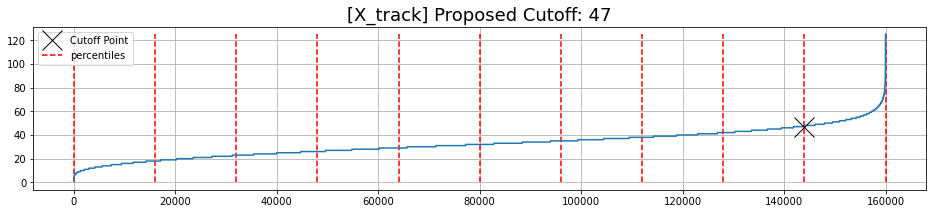

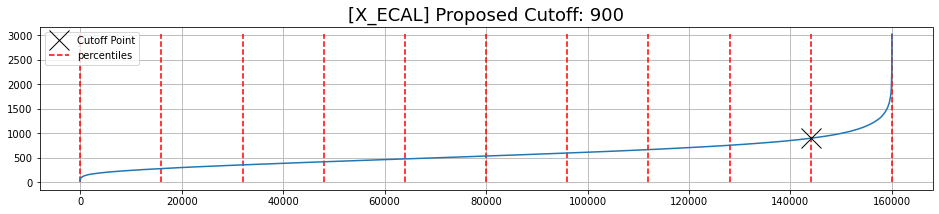

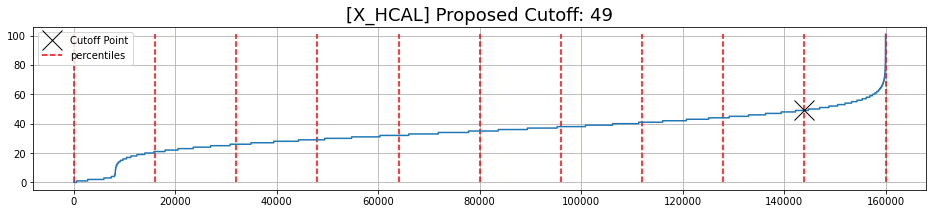

In [11]:
''' ANALYSIS OF PARSED DATASET '''

def analyse_dataset(Xs, labels):
    l = len(Xs[0])

    for i, Xi in enumerate(Xs):
        plt.figure(figsize=[16,3])

        X_lens = sorted([len(t[0]) for t in Xi])[:l]
        X_points = np.arange(0, l+0.1, l/10)
        cutoff = X_lens[int(X_points[9])]

        title = '[{}] Proposed Cutoff: {}'.format(labels[i], cutoff)
        plt.title(title, size=18)
        plt.plot(X_lens)
        plt.vlines(X_points, ymin=0, ymax=max(X_lens), 
                   linestyles='--', color='r', label='percentiles')
        plt.plot(X_points[9], cutoff, 'xk', markersize=20, 
                 label='Cutoff Point')

        plt.grid()
        plt.legend()
        plt.show()    
        
if DO_ANALYSIS:
    analyse_dataset([X_track, X_ECAL, X_HCAL], 
                    labels=['X_track', 'X_ECAL', 'X_HCAL'])

In [12]:
''' FUNCTIONS: PAD/MERGE ALL THREE CHANNELS '''

def pad_array(outer_array, output_len, pad_value=0):
    outer_array_pad = []
    for tri_array in tqdm(outer_array, leave=False):
        tri_array_pad = []
        for inner_arr in tri_array:
            inner_arr = inner_arr[:output_len]
            pad_len = output_len - len(inner_arr)
            inner_arr_pad = np.pad(inner_arr, (0, pad_len))
            tri_array_pad.append(inner_arr_pad)
        outer_array_pad.append(tri_array_pad)
    outer_array_pad = np.array(outer_array_pad)
    return outer_array_pad

def standardise_merge_arrays(X_track, X_ECAL, X_HCAL, MAX_INSTANCES):
    X_track = pad_array(X_track, MAX_INSTANCES['X_track'])
    X_ECAL = pad_array(X_ECAL, MAX_INSTANCES['X_ECAL'])
    X_HCAL = pad_array(X_HCAL, MAX_INSTANCES['X_HCAL'])
    
    X = []
    for i in range(len(X_track)):
        X_instance = np.concatenate([X_track[i].flatten(), 
                                     X_ECAL[i].flatten(),
                                     X_HCAL[i].flatten()])
        X.append(X_instance)
    X = np.array(X)
    
    print('Max Instances: ', MAX_INSTANCES)
    print('Shape of Individual arrays:', X_track.shape, X_ECAL.shape, X_HCAL.shape)
    print('Shape of Combined array:', X.shape)
    return X

In [13]:
''' MERGING ALL THREE CHANNELS INTO SINGLE ARRAY '''

MAX_INSTANCES = {
    'X_track': 56,   # 90 percentile is  47  
    'X_ECAL': 912,   # 90 percentile is 898
    'X_HCAL': 56,    # 90 percentile is  49
}

# Merge into single array
X = standardise_merge_arrays(X_track, X_ECAL, X_HCAL, MAX_INSTANCES)

# Delete previous arrays to save memory
del X_track, X_ECAL, X_HCAL

  0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

Max Instances:  {'X_track': 56, 'X_ECAL': 912, 'X_HCAL': 56}
Shape of Individual arrays: (160000, 3, 56) (160000, 3, 912) (160000, 3, 56)
Shape of Combined array: (160000, 3072)


# Outlining the Training Pipeline

In [14]:
''' DOING IMPORTS '''

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [15]:
''' FUNCTIONS: SPLIT DATASET, CREATE DATALOADERS ''' 

def split_dataset(X, test_size = 0.1, valid_size = 0.1):
    test_size1 = test_size
    test_size2 = test_size / (1 - valid_size)   # Normalize
    
    X_train, X_test = train_test_split(X, 
                                       test_size=test_size1, 
                                       random_state=0)
    X_train, X_valid = train_test_split(X_train, 
                                        test_size=test_size2, 
                                        random_state=0) 
    return X_train, X_valid, X_test

def get_dataLoader(X, cfg):
    ''' Constructs DataLoaders from (X) instances.
    '''
    dataset = TensorDataset(torch.Tensor(X)) 
    dataLoader = DataLoader(dataset, 
                            batch_size=cfg['batch_size'], 
                            num_workers=cfg['num_workers']) 
    return dataLoader

In [16]:
''' CLASS DEFINITION: PYTORCH AUTOENCODER MODEL '''

class AutoEncoder(nn.Module):
    def __init__(self, n_features, layers):
        super(AutoEncoder, self).__init__()
        
        self.layers = [n_features] + layers
        self.rev_layers = self.layers[::-1]
        self.n = len(self.layers)
        
        encoder_layers = []
        for i in range(0, self.n-1):
            en_layer = nn.Linear(self.layers[i], self.layers[i+1])
            bn_layer = nn.BatchNorm1d(self.layers[i+1])
            encoder_layers.append(en_layer)
            if i != self.n-2 :
                encoder_layers += [bn_layer, nn.ReLU()]
        self.encoder = nn.ModuleList(encoder_layers)
            
        decoder_layers = []
        for i in range(self.n-1, 0, -1):
            de_layer = nn.Linear(self.layers[i], self.layers[i-1])
            bn_layer = nn.BatchNorm1d(self.layers[i-1])
            decoder_layers.append(de_layer)
            if i != 1 :
                decoder_layers += [bn_layer, nn.ReLU()]
        self.decoder = nn.ModuleList(decoder_layers)
        
    def encode(self, x):
        for layer in self.encoder:
            x = layer(x)
        return x
    
    def decode(self, x):
        for layer in self.decoder:
            x = layer(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def describe(self):
        print("LAYERS: ", self.layers)
        print("\nENCODER: \n============")
        print(self.encoder)
        print("\nDECODER: \n============")
        print(self.decoder)

In [17]:
''' CLASS DEFINITION: PYTORCH-LIGHTNING CLASSIFIER FOR TRAINING '''

# Define the training logic.
class Classifier(pl.LightningModule):
    def __init__(self, cfg):
        super(Classifier, self).__init__()
        self.save_hyperparameters(cfg)

        n_features = sum([cfg['MAX_INSTANCES'][k] for k in cfg['MAX_INSTANCES']]) * 3
        self.model = AutoEncoder(n_features, cfg['layers']).to(cfg['device'])
        self.criterion = nn.MSELoss()
        self.sched = cfg['scheduler']
        self.lr = cfg['learning_rate']
        self.opt = cfg['optimizer']
        self.cfg = cfg
        self.predictions = []
        # print(self.cfg)
        # self.model.describe()

    def training_step(self, batch, batch_idx):
        X = batch[0]
        preds = self.model(X)
        loss = self.criterion(preds, X)
        self.log('Train_Loss', loss.detach(), 
                 on_step=True, on_epoch=True, prog_bar=True)  
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        X = batch[0]
        preds = self.model(X)
        loss = self.criterion(preds, X)
        self.log('Valid_Loss', loss.detach(), 
                 on_step=False, on_epoch=True, prog_bar=True)
        return {'loss': loss}
    
    def test_step(self, batch, batch_idx):
        X = batch[0]
        preds = self.model(X)
        self.predictions += preds.detach().cpu()
        loss = self.criterion(preds, X)
        return {'test_loss': loss}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        self.log('avg_test_loss', avg_loss)
        
    def configure_optimizers(self):
        assert self.lr is not None
        
        # Optimizer
        if self.opt == 'adam':
            optimizer = Adam(self.parameters(), lr=self.lr)
        elif self.opt == 'adamw':
            optimizer = AdamW(self.parameters(), lr=self.lr)
        elif self.opt == 'rmsprop':
            optimizer = RMSprop(self.parameters(), lr=self.lr)
        elif self.opt == 'sgd':
            optimizer = SGD(self.parameters(), lr=self.lr)
        else:
            raise NotImplementedError("Undefined Optimizer.") 
        
        # Scheduler
        if self.sched == None:
            return {'optimizer': optimizer}
        elif self.sched == 'ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, verbose=True)
        elif self.sched == 'LambdaLR':
            scheduler = LambdaLR(optimizer, verbose=True)
        else:
            raise NotImplementedError("Undefined Scheduler.") 
        
        return {'optimizer': optimizer, 
                'lr_scheduler': scheduler, 
                'monitor': 'Valid_Loss'}

In [18]:
''' DEFINE THE EXPERIMENT CONFIG FILE '''

# Defining various parameters.
cfg = {
    # Model Parameters
    'layers': [2048, 1024, 512, 256],
    
    # DataLoader Parameters
    'batch_size': 1024,
    'num_workers': 32,

    # Training Parameters
    'device': torch.device('cuda:0'),   # Replace with 'cpu' if not using GPU.
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'scheduler': None,                  # 'ReduceLROnPlateau',
    'model_name': 'model1',
    'log_dir': 'logs',
    'checkpoint_count': 3,
    'callbacks': ['ModelCheckpoint']    # ['ModelCheckpoint', 'EarlyStopping']   
}

# Config for PyTorch Lightning Trainer.
PyTorch_Lightning_Trainer_cfg = {
    'max_epochs' : 1000,
    'weights_summary' : None,
    'gpus': [0],                        # Replace with [] if not using GPU.
    'log_every_n_steps': 5,
    'check_val_every_n_epoch': 1
    
    ### Other Trainer settings ###
    # 'precision': 16
    # 'auto_lr_find': True,
    # 'overfit_batches' : 0.001, 
    # 'val_check_interval': 1.0,
    # 'limit_train_batches': 10,
    # 'limit_val_batches': 0,
    # 'progress_bar_refresh_rate': 0
}

# Cache in main config for later reference.
cfg['PL_CONFIG'] = PyTorch_Lightning_Trainer_cfg
cfg['MAX_INSTANCES'] = MAX_INSTANCES

In [19]:
''' FUNCITONS: CALLBACK AND LOGGER DEFINITIONS '''

def get_callbacks(cfg):
    ''' Load callbacks specified in the config.
    '''
    callbacks = []
    for callback_ID in cfg['callbacks']:
        if callback_ID == 'ModelCheckpoint':
            callbacks += [ModelCheckpoint(monitor='Valid_Loss',
                                         filename='{epoch:04d}_{Valid_Loss:.3f}',
                                         save_top_k=cfg['checkpoint_count'],
                                         save_last=True,
                                         mode='min', 
                                         verbose=True)]
        elif callback_ID == 'EarlyStopping':
            callbacks += [EarlyStopping(monitor='Valid_Loss',
                                       min_delta=0.00,
                                       patience=20,
                                       mode='min',
                                       verbose=True)]
        else:
            raise NotImplementedError('Callback not defined.')
    return callbacks

def get_logger(cfg):
    ''' Load logger using settings specified in the config.
    '''
    logger = TensorBoardLogger(cfg['log_dir'], name=cfg['model_name'])
    return logger

# Training The Model

In [20]:
''' DATA PREPERATION '''

# Split the dataset.
X_train, X_valid, X_test = split_dataset(X)
print("Length of Datasets:", len(X_train), len(X_valid), len(X_test))

# Get the Data Loaders
train_dataLoader = get_dataLoader(X_train, cfg)
valid_dataLoader = get_dataLoader(X_valid, cfg)
test_dataLoader = get_dataLoader(X_test, cfg)
print('Number of Batches :', 
      len(train_dataLoader), len(valid_dataLoader), len(test_dataLoader))

Length of Datasets: 127999 16001 16000
Number of Batches : 125 16 16


In [21]:
# Define the Pytorch-Lighting trainer using config settings
trainer = pl.Trainer(callbacks = get_callbacks(cfg), 
                     logger = get_logger(cfg),
                     **cfg['PL_CONFIG'])

# Instantiate the above defined Classifier
classifier = Classifier(cfg).to(cfg['device'])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [22]:
# Load previous trained checkpoint for further training.
# NOTE: Is Optional if training.

if not DO_TRAINING:
    CKPT_PATH = 'logs/model1/version_40/checkpoints/epoch=0209_Valid_Loss=28.695.ckpt'
    classifier = classifier.load_from_checkpoint(CKPT_PATH)

In [23]:
# Train the model
# NOTE: Optimally you want to load previous checkpoints and 
#       continue Training for better results. 

if DO_TRAINING:
    trainer.fit(classifier, train_dataLoader, valid_dataLoader)

## Training Curves from Tensorboard

**Training Loss**
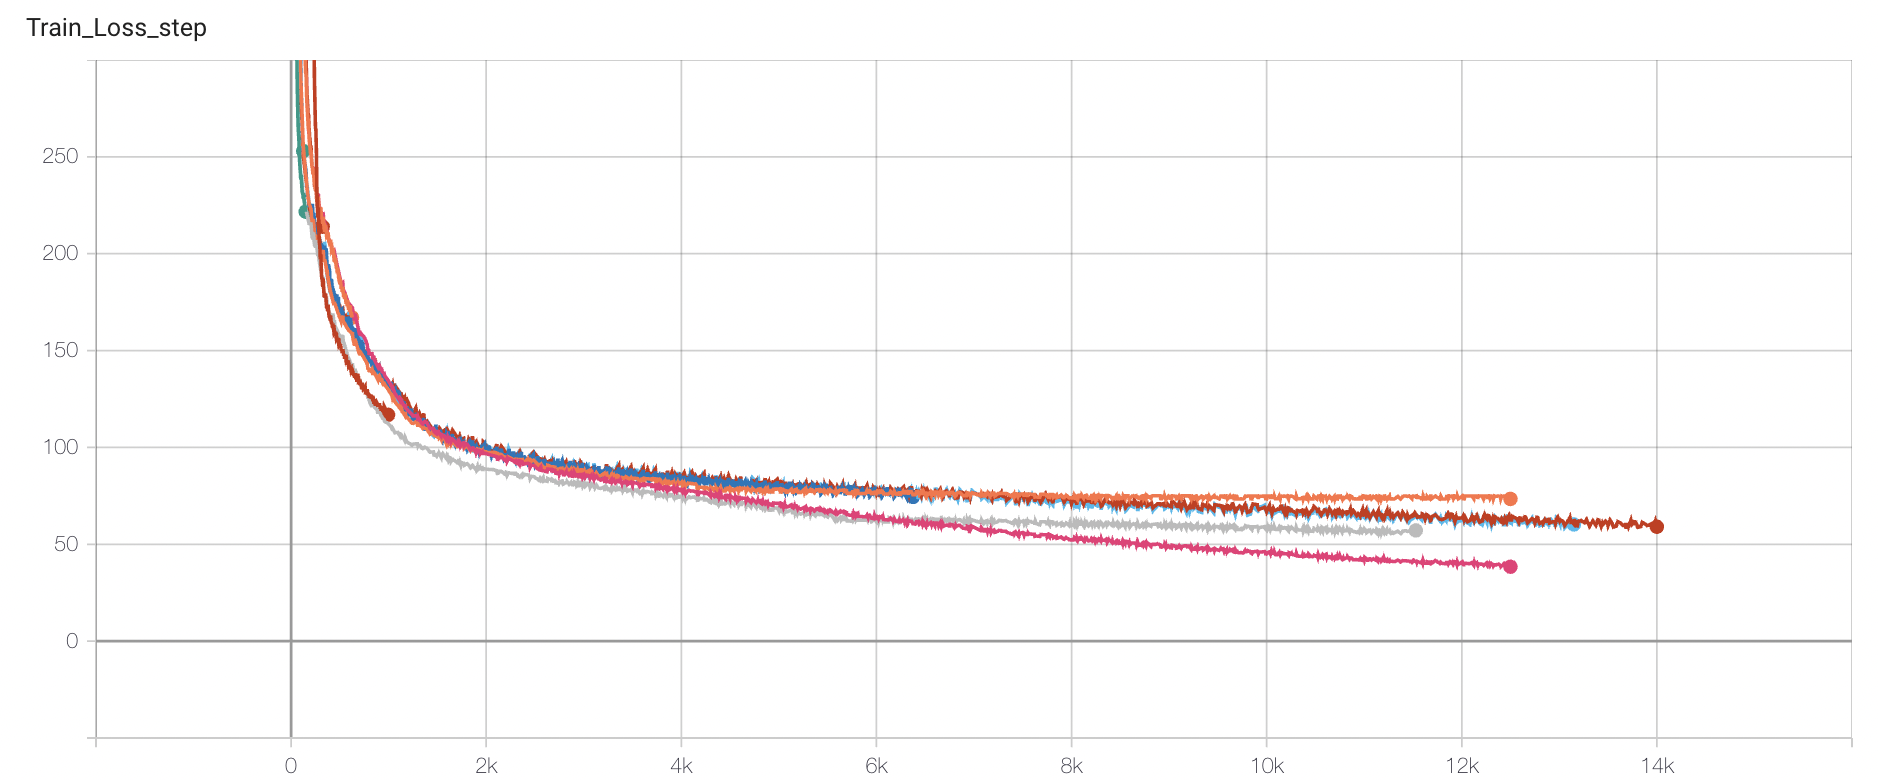

**Validation Loss**
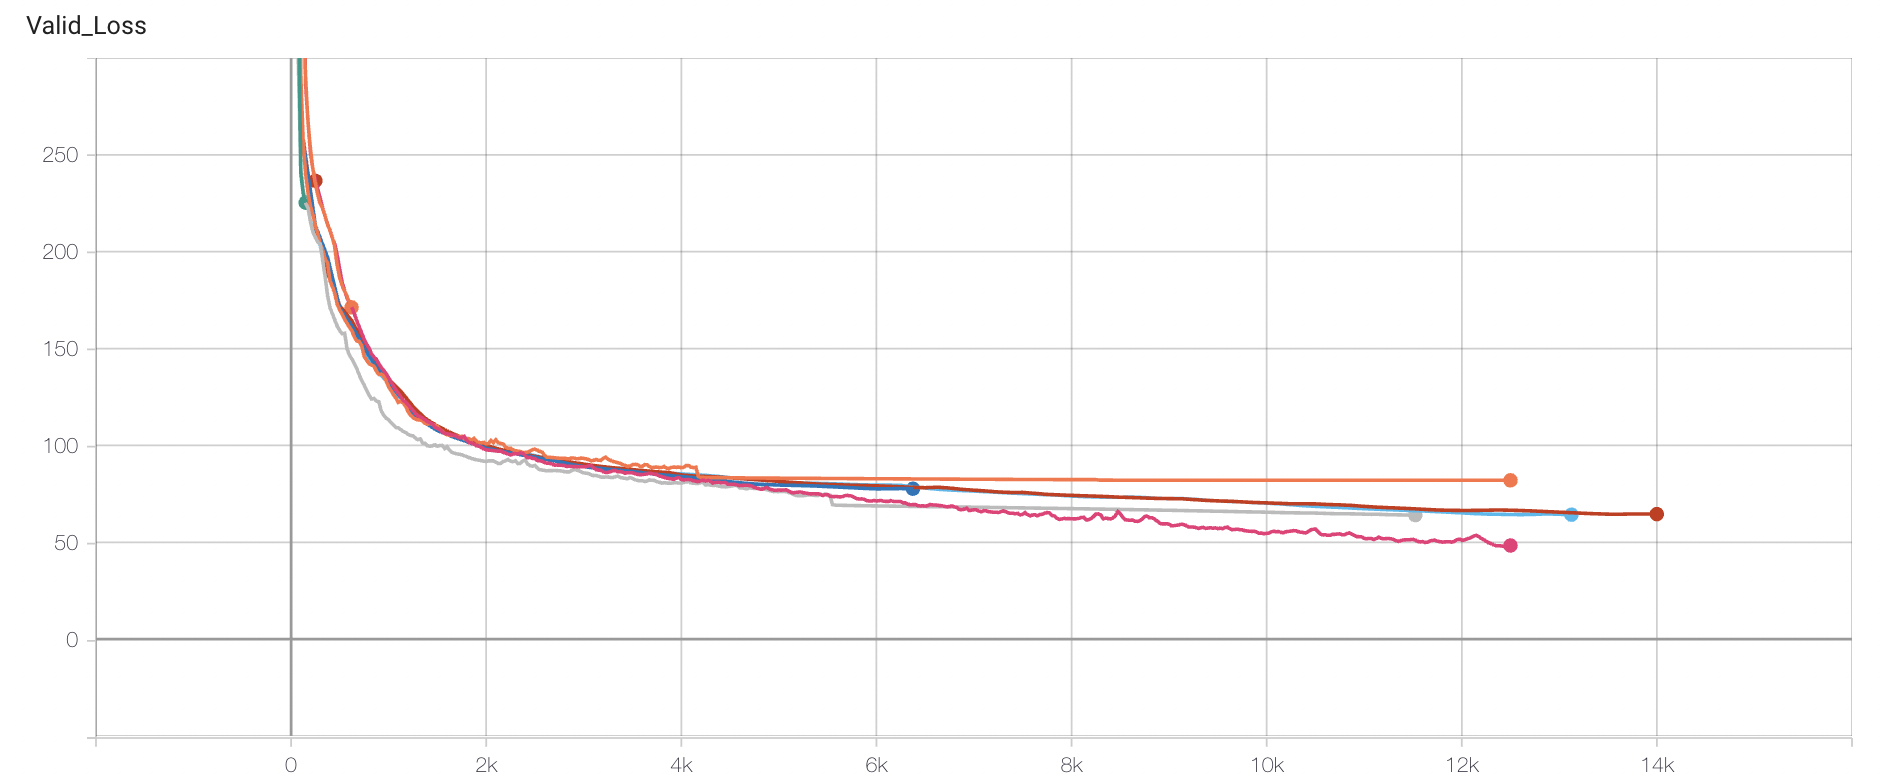

# Evaluate the Trained Model

In [24]:
from scipy.stats import wasserstein_distance as emd

In [25]:
''' FUNCTIONS: GET PREDICTIONS, CALCULATE METRICS '''

def get_eval_preds(classifier, trainer, dataLoader):
    ''' Get predictions from a trained model (`classifier` + 
        `trainer`), on a dataset (`dataLoader`). 
    '''
    classifier.predictions = []
    training_metrics = trainer.test(classifier, 
                                    test_dataloaders=dataLoader, 
                                    verbose=False)
    preds = np.array([p.numpy() for p in classifier.predictions])
    return preds

def get_EMD(preds, X, lim=10000):
    ''' Calculate the Earth Mover Distance (EMD) metric between 
        the ground truth (`X`) and the predictions (`preds`).
    '''
    EMD = []
    lim = min(lim, len(X))
    for idx in range(lim):
        EMD += [emd(preds[idx], X[idx])]
    return EMD

def plot_hist(EMD):
    ''' Plot EMD histogram.
    '''
    plt.figure(figsize=[16,5])
    plt.grid()
    plt.hist(EMD, bins=100, edgecolor='k')
    plt.title('EMD Values for reconstructed Events', size=18)
    plt.ylabel('Number of Events', size=14)
    plt.xlabel('EMD Value', size=14)
    plt.show()

def evaluate(classifier, trainer, dataLoader, X, split):
    ''' Evaluate a model (`classifier` + `trainer`) on a 
        dataset (`dataLoader` + `X`). Outputs dataset mean, 
        RMSE and EMD (Earth Mover Distance) metrics.
    '''
    preds = get_eval_preds(classifier, trainer, dataLoader)
    RMSE = mean_squared_error(preds, X, squared=False)
    EMD = get_EMD(preds, X)
    MEAN = np.mean(X)
    print('Data Split :', split)
    print('RMSE Error : {:.3f} ± {:.3f}'.format(MEAN, RMSE))
    print('Average EMD: {:.3f}'.format(np.mean(EMD)))
    plot_hist(EMD)

Testing: 0it [00:00, ?it/s]

Data Split : Train
RMSE Error : 24.799 ± 3.772
Average EMD: 0.970


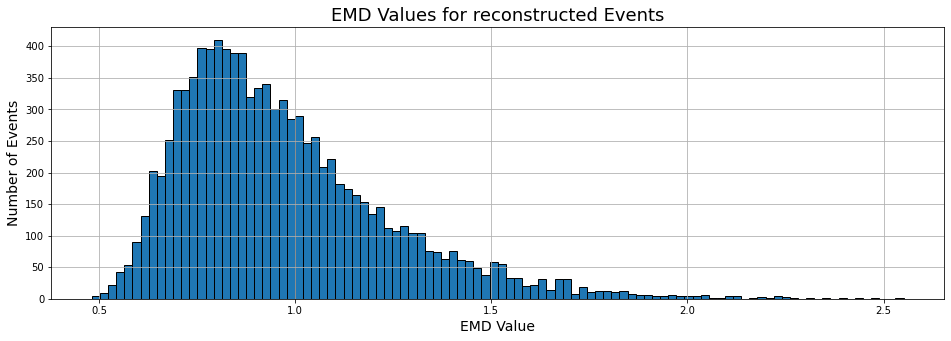

Testing: 0it [00:00, ?it/s]

Data Split : Valid
RMSE Error : 24.852 ± 4.020
Average EMD: 1.015


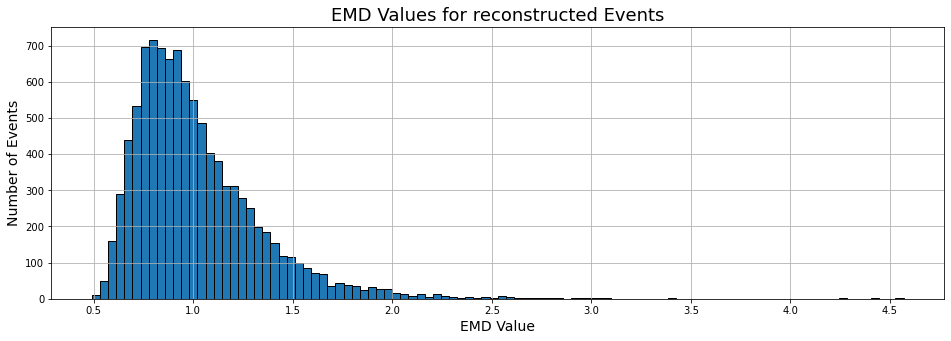

Testing: 0it [00:00, ?it/s]

Data Split : Test
RMSE Error : 24.795 ± 4.021
Average EMD: 1.021


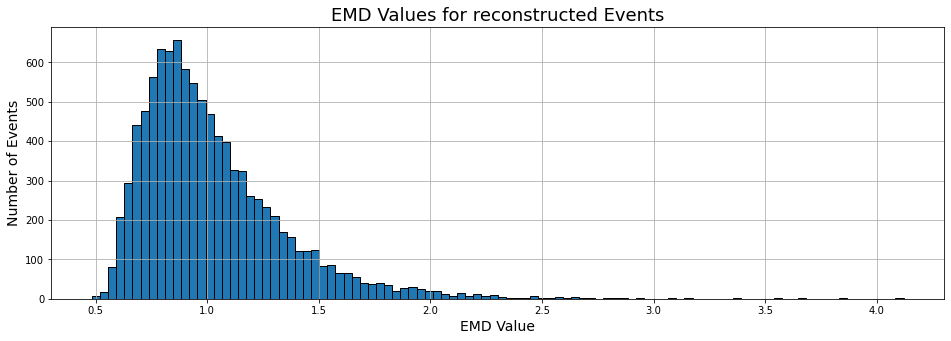

In [26]:
''' LOAD PREVIOUS CHECKPOINT AND EVALUATE IT '''

if DO_ANALYSIS:
    # Load a previous checkpoint for evaluation
    CKPT_PATH = 'logs/model1/version_40/checkpoints/epoch=0221_Valid_Loss=28.734.ckpt'
    classifier = classifier.load_from_checkpoint(CKPT_PATH)

    # Evaluate trained model on different split
    evaluate(classifier, trainer, train_dataLoader, X_train, 'Train')
    evaluate(classifier, trainer, valid_dataLoader, X_valid, 'Valid')
    evaluate(classifier, trainer, test_dataLoader, X_test, 'Test')

In [27]:
''' FUNCTIONS: PREDICTIONS TO IMAGES, VISUALISING PREDICTIONS '''

def unpad_arr(arr):
    ''' Remove [0,0,0] elements from `arr`.
        Unpads the the input array.
    '''
    idx = np.where(np.any(arr != [0,0,0], axis=1))[0]
    arr = arr[idx]
    return arr

def arr_to_image(arr, reduced=False):
    ''' Set `reduced` to True if `reduce` was set to True 
        in `parse_dataset` before AND the model predictions
        are required in the original format. In case the 
        predictions are not required in the original format, 
        set it to `False`.
    '''
    
    if reduced:
        img = np.zeros([125,125])
        for e in arr:
            for i in range(5):
                for j in range(5):
                    img[int(e[0]+i), int(e[1]+j)] = e[2]
    else:
        img = np.zeros([125,125])
        for e in arr:
            img[int(e[0]), int(e[1])] = e[2]
    return img

def reshape_arr(arr):
    arr = arr.reshape(3, -1)
    arr = np.array([arr[:,i] for i in range(arr.shape[1])])
    return arr
    
def decode_pred(arr, cfg):
    ''' Given a model prediction, returns a 3 channel image
        corresponding to it. 
    '''
    splits = [cfg['MAX_INSTANCES'][k] for k in cfg['MAX_INSTANCES']]
    splits = [3*sum(splits[:i+1]) for i in range(len(splits))]
    
    X_track = arr[:splits[0]]
    X_ECAL = arr[splits[0]:splits[1]]
    X_HCAL = arr[splits[1]:]
    X_track = arr_to_image(unpad_arr(reshape_arr(X_track)))
    X_ECAL = arr_to_image(unpad_arr(reshape_arr(X_ECAL)))
    X_HCAL = arr_to_image(unpad_arr(reshape_arr(X_HCAL)))
    return X_track, X_ECAL, X_HCAL

def vis_pair(img1, img2, title=None, scale=1000, cmap='gist_heat', reduce=False):  
    ''' Function to visualize a pair of images consisting
        of the input (`img1`) and it's reconstruction (`img2`).
    '''
    x_pos1, y_pos1, val1 = parse_img(img1, reduce)
    x_pos2, y_pos2, val2 = parse_img(img2, reduce)
    if scale:
        sz1 = np.array(np.abs(val1))*scale
        sz2 = np.array(np.abs(val2))*scale
    else:
        sz1 = np.ones_like(val1) * 10
        sz2 = np.ones_like(val2) * 10
        
    plt.figure(figsize=[16,6], facecolor='#f0f0f0')
    if title:
        plt.suptitle(title, size=20)
    cm = plt.cm.get_cmap(cmap) 
    
    plt.subplot(1, 2, 1)
    plt.title('Input', size=16)
    sc = plt.scatter(x_pos1, y_pos1, c=val1, s=sz1, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 125)
    plt.ylim(0, 125)
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.title('Reconstruction', size=16)
    sc = plt.scatter(x_pos2, y_pos2, c=val2, s=sz2, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 125)
    plt.ylim(0, 125)
    plt.grid()
    
    plt.show()

Testing: 0it [00:00, ?it/s]

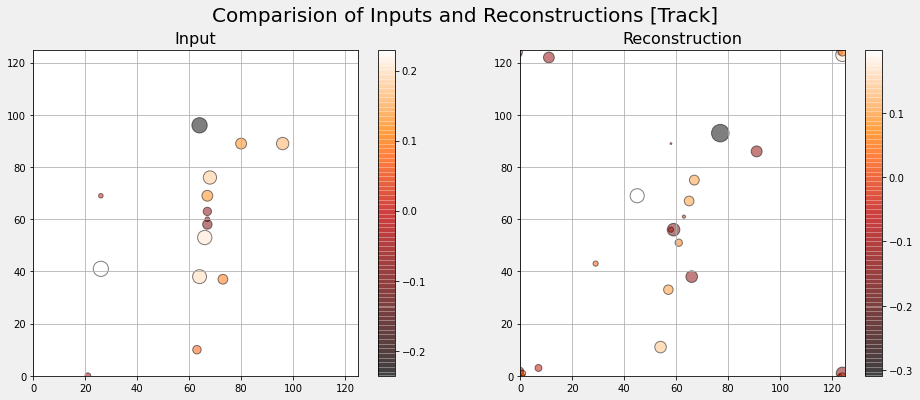

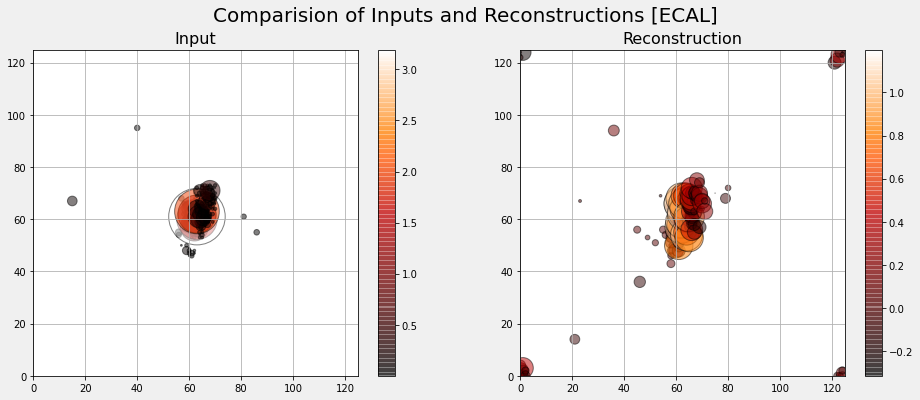

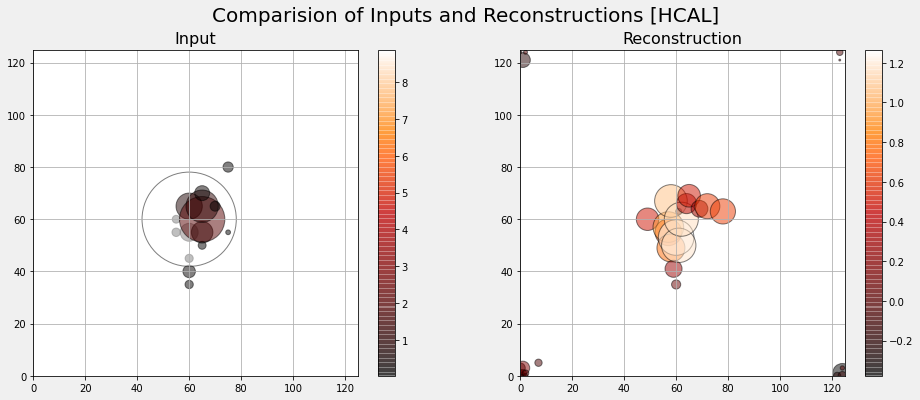

In [28]:
''' COMPARE INPUTS AND RECONSTRUCTIONS '''

if DO_ANALYSIS:
    IDX = 89389     # Index to compare.
    preds = get_eval_preds(classifier, trainer, train_dataLoader)

    pred_img = decode_pred(preds[IDX], cfg)
    orig_img = decode_pred(X_train[IDX], cfg)

    title = 'Comparision of Inputs and Reconstructions '
    vis_pair(orig_img[0], pred_img[0], title = title+'[Track]')
    vis_pair(orig_img[1], pred_img[1], title = title+'[ECAL]')
    vis_pair(orig_img[2], pred_img[2], title = title+'[HCAL]')